In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [48]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

font = {'size': 22}

matplotlib.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
import scipy.stats
import seaborn as sns

import sklearn.datasets

import mrob

# Pose compounding

In [49]:
T_1 = mrob.geometry.SE3([0,0,0,1,0,0])
sigma_1 = np.diag([0,0,0.03**2,0,0,0])
T_1.T()

array([[1., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [50]:
T_2 = mrob.geometry.SE3([0,0,0,0,1,0])
sigma_2 = np.diag([0,0,0.03**2,0,0,0])
T_2.T()

array([[1., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

## Second order

In [51]:
T = T_1.mul(T_2)

In [52]:
T_1_adj = T_1.adj()
T_1_adj

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.]])

In [53]:
xi_2_ = T_1_adj @ xi_2
xi_2_

array([0., 0., 0., 0., 1., 0.])

In [54]:
sigma_2_ = T_1_adj@sigma_2@T_1_adj.transpose()

In [55]:
sigma = sigma_1 + sigma_2_

In [56]:
def compound_2nd(T1, sigma1, T2, sigma2):
    T = T_1.mul(T_2)
    T_1_adj = T_1.adj()
    sigma_2_ = T_1_adj@sigma_2@T_1_adj.transpose()
    sigma = sigma_1 + sigma_2_
    return T, sigma

In [57]:
T, sigma = compound_2nd(T_1, sigma_2,T_2, sigma_2)

<AxesSubplot:>

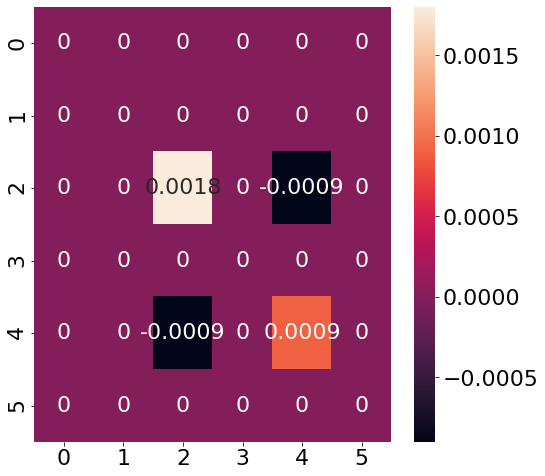

In [58]:
plt.figure(figsize=(8,8))
sns.heatmap(sigma,annot=True)

## Cholesky for block matrix

In [59]:
def cholesky(sigma):
    condition =~ (np.all(sigma == 0, axis=1) & (np.all(sigma == 0, axis=0)))
    m = [int(x) for x in condition]
    counter = 0
    res = []
    for el in m:
        if el > 0:
            res.append(counter)
            counter +=1
        else:
            res.append(None)
    M = []    
    for i in range(6):
        tmp = []
        for j in range(6):
            tmp.append([res[i],res[j]])
        
        M.append(tmp)
    M = np.array(M)
    
    block = (sigma[condition,:])[:,condition]

    L = np.linalg.cholesky(block)
    LL = np.zeros_like(sigma)
    
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            if all(M[i,j] != None):
                k = M[i,j][0]
                l = M[i,j][1]
            
                LL[i,j] = L[k,l]
        
    return LL

In [60]:
A = cholesky(sigma)
print(A)

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.04242641  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.0212132   0.          0.0212132   0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


In [61]:
np.linalg.norm(sigma - A@A.transpose())

2.168404344971009e-19

<AxesSubplot:>

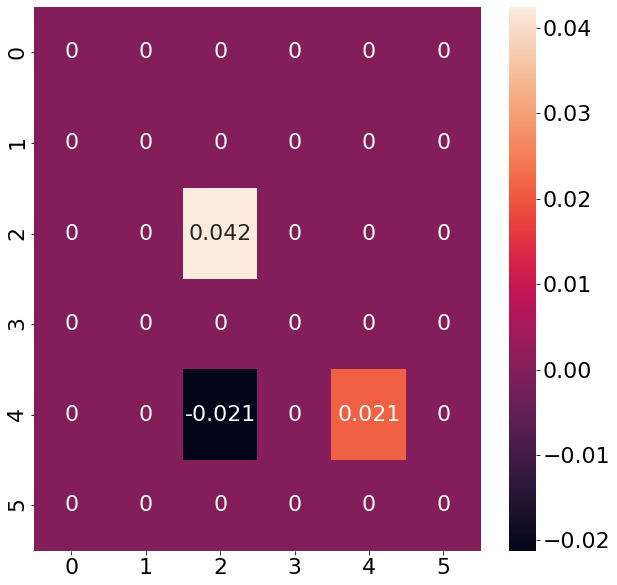

In [62]:
plt.figure(figsize=(10,10))
sns.heatmap(A,annot=True)

In [63]:
N = 100
error = 0
for _ in range(N):
    tmp = np.random.randn(6)+5
    tmp[np.random.randint(0,6)] = 0
    sigma = np.diag(tmp)
    L = cholesky(sigma)
    error += np.linalg.norm(sigma - L@L.transpose())

print("Mean error: {}".format(error/N))

Mean error: 1.3455801921401031e-15
